In [6]:
from lora.models.roberta import get_model
from omegaconf import OmegaConf
import numpy as np
import scipy as scp

import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

In [2]:
args = OmegaConf.load('../config.yaml')

In [3]:
model = get_model(args)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
s_list = [[], [], []]
for i in range(model.encoder.config.num_hidden_layers):
    Wq = model.encoder.encoder.layer[i].attention.self.query.weight.detach().numpy()
    s_list[0].append(scp.linalg.svdvals(Wq))

    Wk = model.encoder.encoder.layer[i].attention.self.key.weight.detach().numpy()
    s_list[1].append(scp.linalg.svdvals(Wk))

    Wv = model.encoder.encoder.layer[i].attention.self.value.weight.detach().numpy()
    s_list[2].append(scp.linalg.svdvals(Wv))

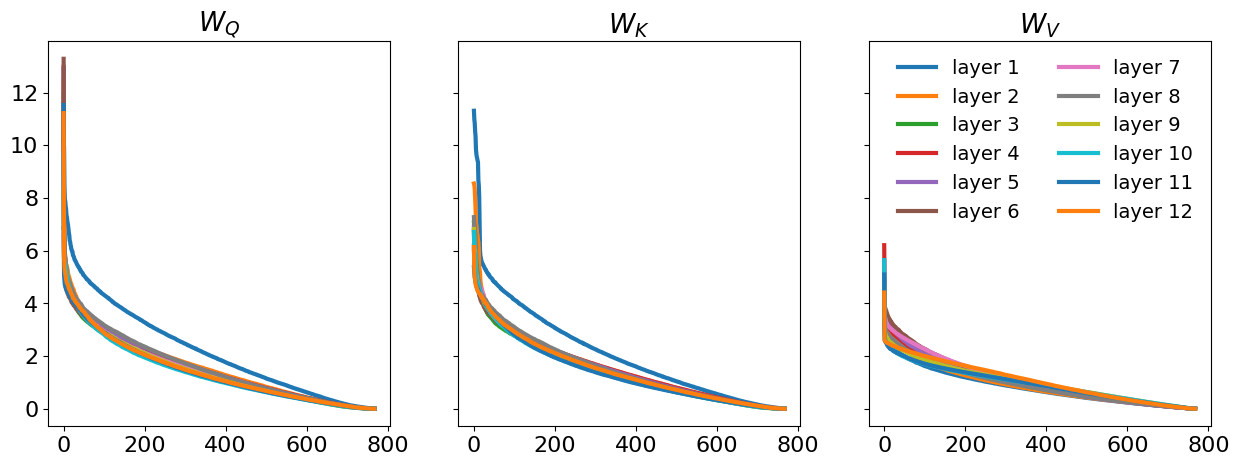

In [12]:
types = [r"$W_Q$", r"$W_K$", r"$W_V$"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, type in enumerate(types):
    ax = axes[i]
    for j, s_vals in enumerate(s_list[i]):
        ax.plot(list(range(len(s_vals))), s_vals, label=f"layer {j+1}", lw=3)
    ax.set_title(type)
ax.legend(frameon=False, ncols=2, fontsize=14)
plt.savefig("roberta_spectrums.pdf", bbox_inches='tight')

In [13]:
b_list = []
for i in range(model.encoder.config.num_hidden_layers):
    Wq = model.encoder.encoder.layer[i].attention.self.query.weight.detach().numpy()
    Wk = model.encoder.encoder.layer[i].attention.self.key.weight.detach().numpy()
    B = Wq @ Wk.T
    b_list.append(scp.linalg.svdvals(B))

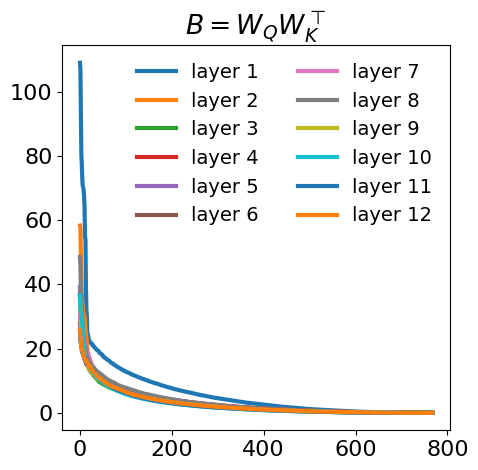

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
for j, s_vals in enumerate(b_list):
        ax.plot(list(range(len(s_vals))), s_vals, label=f"layer {j+1}", lw=3)
ax.legend(frameon=False, ncols=2, fontsize=14)
ax.set_title(r"$B = W_Q W_K^\top$")
plt.savefig("B_spectrum.pdf", bbox_inches='tight')

In [ ]:
B = Wq @ Wk.T

In [ ]:
U, S, Vt = scp.linalg.svd(B, full_matrices=Faxlse)

In [ ]:
r_list = np.arange(1, len(S), 1)
approx_err = []
for r in r_list:
    Sr = np.copy(S)
    Sr[r:] = 0
    Bh = U @ np.diag(Sr) @ Vt
    approx_err.append(np.linalg.norm(B - Bh, ord='fro'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


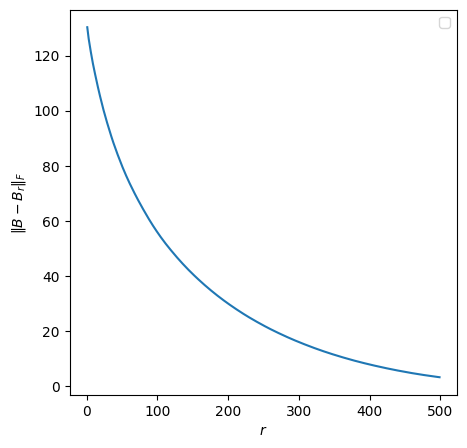

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(r_list, approx_err)
ax.legend()
ax.set_ylabel(r"$\| B - B_r \|_F$")
ax.set_xlabel(r"$r$")
plt.show()

### Current Experiment

In [1]:
from lora.models.roberta import get_model   
from omegaconf import OmegaConf
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
from lora.compress.gregodec import GreGoDec
from transformers import RobertaModel
from transformers import RobertaTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import math

/cis/home/adesilva/miniconda3/envs/myllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
args = OmegaConf.load('/cis/home/adesilva/ashwin/research/cs-project/config.yaml')
model = get_model(args)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# tokenize the entire dataset
dataset = load_dataset("nyu-mll/glue", "sst2")
dataset = dataset.map(
    lambda e: tokenizer(
        e["sentence"],
        None,
        max_length=256,
        pad_to_max_length=True,
        return_token_type_ids=True,
    ),
    batched=True,
)
dataset.set_format(
            type="torch",
            columns=["input_ids", "token_type_ids", "attention_mask", "label"],
        )
dataloader = DataLoader(
            dataset["validation"],
            batch_size=16,
            shuffle=False,
            num_workers=4
)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/cis/home/adesilva/miniconda3/envs/myllm/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Map: 100%|█████████

In [46]:
activation = {}
def get_embeddings(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [52]:
encoder = RobertaModel.from_pretrained("roberta-base").to(device)
encoder.embeddings.register_forward_hook(get_embeddings('embeddings'))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
query = model.encoder.encoder.layer[0].attention.self.query
key = model.encoder.encoder.layer[0].attention.self.key
value = model.encoder.encoder.layer[0].attention.self.value

Wq = torch.vstack([query.weight.transpose(0, 1), query.bias]).cpu().numpy()
Wk = torch.vstack([key.weight.transpose(0, 1), key.bias]).cpu().numpy()
B = Wq @ Wk.T

In [14]:
U, V, S, error = GreGoDec(
    D = B,
    rank = 100,
    tau = 0.5,
    tol = 1e-2, 
    power = 10,
    k = 5
).fit()

In [53]:
data = next(iter(dataloader))
y = encoder(
    input_ids=data["input_ids"].long().to(device),
    attention_mask=data["attention_mask"].long().to(device),
    token_type_ids=data["token_type_ids"].long().to(device)
)

In [19]:
X = activation["embeddings"][15].cpu()
X = torch.cat([X, torch.ones(X.size()[:-1] + (1,))], dim=-1).numpy()

Y = softmax(X @ B @ X.T / np.sqrt(B.shape[0])) 
Yhat = softmax(X @ (U @ V) @ X.T / np.sqrt(B.shape[0]))

In [20]:
print(f"error : {np.linalg.norm(Y - Yhat, ord='fro')}")

error : 0.059094782918691635


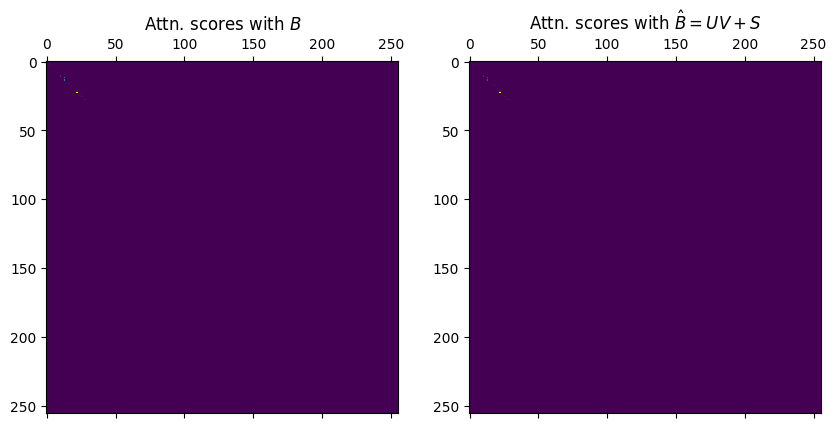

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.matshow(Y)
ax.set_title(r"Attn. scores with $B$")

ax = axes[1]
ax.matshow(Yhat)
ax.set_title(r"Attn. scores with $\hat B = UV + S$")
plt.show()

In [48]:
def transpose_for_scores(x):
     new_x_shape = x.size()[:-1] + (12, 64)
     x = x.view(*new_x_shape)
     return x.permute(0, 2, 1, 3)

In [49]:
query = model.encoder.encoder.layer[0].attention.self.query
key = model.encoder.encoder.layer[0].attention.self.key
value = model.encoder.encoder.layer[0].attention.self.value

In [56]:
X = activation["embeddings"][15]
X = X[None, :]
K = transpose_for_scores(key(X))
Q = transpose_for_scores(query(X))
V = transpose_for_scores(value(X))

In [57]:
attention_scores = torch.matmul(Q, K.transpose(-1, -2))
attention_probs = nn.Softmax(dim=-1)(attention_scores)

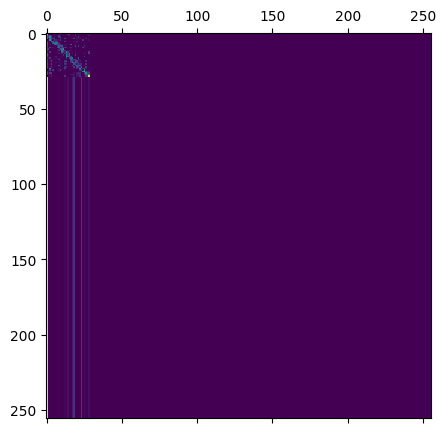

In [112]:
A = attention_probs.cpu().detach().numpy().squeeze().sum(axis=0)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(A)

In [91]:
Wq = torch.vstack([query.weight.transpose(0, 1), query.bias])
Wk = torch.vstack([key.weight.transpose(0, 1), key.bias])
X_ = torch.cat([X, torch.ones(X.size()[:-1] + (1,)).to(device)], dim=-1)
X_ = X_[None, :]

In [92]:
Wq = Wq.view(769, 12, 64)
Wq = Wq.permute(1, 0, 2)

Wk = Wk.view(769, 12, 64)
Wk = Wk.permute(1, 0, 2)

In [97]:
Q_ = torch.matmul(X_, Wq)
K_ = torch.matmul(X_, Wk)
A_ = torch.matmul(Q_, K_.transpose(-1, -2))

In [100]:
B_ = torch.matmul(Wq, Wk.transpose(-1, -2))

In [103]:
A__ = torch.matmul(
    torch.matmul(X_, B_),
    X_.transpose(-1, -2)
)

In [105]:
A_

tensor([[[[ 4.0592e+01, -5.2227e-02,  2.2086e+00,  ...,  1.0784e+01,
            1.0784e+01,  1.0784e+01],
          [ 3.3477e+01,  3.0349e+01,  2.6887e+01,  ...,  2.3146e+01,
            2.3146e+01,  2.3146e+01],
          [ 5.1772e+01,  4.2948e+01,  4.0216e+01,  ...,  2.0797e+01,
            2.0797e+01,  2.0797e+01],
          ...,
          [ 5.7027e+01,  4.8570e+00,  9.5451e+00,  ...,  2.0600e+01,
            2.0600e+01,  2.0600e+01],
          [ 5.7027e+01,  4.8570e+00,  9.5451e+00,  ...,  2.0600e+01,
            2.0600e+01,  2.0600e+01],
          [ 5.7027e+01,  4.8570e+00,  9.5451e+00,  ...,  2.0600e+01,
            2.0600e+01,  2.0600e+01]],

         [[ 2.7718e+01, -6.6554e+00,  3.9140e+00,  ...,  4.2957e-01,
            4.2957e-01,  4.2957e-01],
          [ 2.2727e+01,  1.9334e+01,  2.6182e+01,  ...,  1.5908e+01,
            1.5908e+01,  1.5908e+01],
          [ 9.5463e+00,  1.8606e+01,  2.8406e+01,  ...,  2.3316e+01,
            2.3316e+01,  2.3316e+01],
          ...,
     

In [104]:
A__

tensor([[[[ 4.0592e+01, -5.2231e-02,  2.2086e+00,  ...,  1.0784e+01,
            1.0784e+01,  1.0784e+01],
          [ 3.3477e+01,  3.0349e+01,  2.6887e+01,  ...,  2.3146e+01,
            2.3146e+01,  2.3146e+01],
          [ 5.1772e+01,  4.2948e+01,  4.0216e+01,  ...,  2.0797e+01,
            2.0797e+01,  2.0797e+01],
          ...,
          [ 5.7027e+01,  4.8570e+00,  9.5451e+00,  ...,  2.0600e+01,
            2.0600e+01,  2.0600e+01],
          [ 5.7027e+01,  4.8570e+00,  9.5451e+00,  ...,  2.0600e+01,
            2.0600e+01,  2.0600e+01],
          [ 5.7027e+01,  4.8570e+00,  9.5451e+00,  ...,  2.0600e+01,
            2.0600e+01,  2.0600e+01]],

         [[ 2.7718e+01, -6.6554e+00,  3.9140e+00,  ...,  4.2958e-01,
            4.2958e-01,  4.2958e-01],
          [ 2.2727e+01,  1.9334e+01,  2.6182e+01,  ...,  1.5908e+01,
            1.5908e+01,  1.5908e+01],
          [ 9.5463e+00,  1.8606e+01,  2.8406e+01,  ...,  2.3316e+01,
            2.3316e+01,  2.3316e+01],
          ...,
     

### RoBERTa Attention Class

In [22]:
class RobertaSelfAttention(nn.Module):
    def __init__(self, config, manual):
        super().__init__()
        
        self.manual = manual

        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.Wq = torch.vstack([self.query.weight.transpose(0, 1), self.query.bias])
        
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.Wk = torch.vstack([self.key.weight.transpose(0, 1), self.key.bias])

        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        if self.manual:
            B = torch.matmul(self.Wq, self.Wk.transpose(0, 1))
            X = torch.cat([hidden_states, torch.ones(hidden_states.size()[:-1] + (1,))], dim=-1)
            
            attention_scores = torch.matmul(
                torch.matmul(X, B),
                X.permute(0, 2, 1)
            )
        else:
            attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in RobertaModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

In [23]:
torch.manual_seed(1996)
x = torch.randn((1, 514, 768))

In [24]:
attn1 = RobertaSelfAttention(model.encoder.encoder.config, manual=False)
attn2 = RobertaSelfAttention(model.encoder.encoder.config, manual=True)

In [30]:
V = attn1.transpose_for_scores(attn1.value(x))
K = attn1.transpose_for_scores(attn1.key(x))
Q = attn1.transpose_for_scores(attn1.query(x))

In [32]:
attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(attn1.attention_head_size)
attn_probs = nn.Softmax(dim=-1)(attn_scores)

In [34]:
context_layer = torch.matmul(attn_probs, V)

In [35]:
context_layer.shape

torch.Size([1, 12, 514, 64])

In [119]:
y1 = attn1(x)
y1

(tensor([[[-0.0317, -0.0020,  0.0262,  ...,  0.0111, -0.0640,  0.0274],
          [-0.0435,  0.0107,  0.0095,  ...,  0.0175, -0.0855,  0.0200],
          [-0.0489, -0.0115,  0.0375,  ...,  0.0260, -0.0648,  0.0101],
          ...,
          [-0.0333, -0.0228,  0.0099,  ..., -0.0064, -0.0565,  0.0161],
          [-0.0390, -0.0242,  0.0237,  ..., -0.0092, -0.0485,  0.0370],
          [-0.0388, -0.0150, -0.0186,  ..., -0.0046, -0.0581,  0.0302]]],
        grad_fn=<ViewBackward0>),)

In [120]:
y2 = attn2(x)
y2

(tensor([[[-0.0044, -0.0641,  0.0444,  ..., -0.0650,  0.0024,  0.0301],
          [ 0.0008, -0.0884,  0.0291,  ...,  0.0216,  0.0780, -0.0160],
          [ 0.0077,  0.0489, -0.0698,  ..., -0.0180,  0.0778,  0.0162],
          ...,
          [-0.0106,  0.0214, -0.0058,  ..., -0.1214, -0.0998, -0.0349],
          [-0.0185, -0.0532, -0.0099,  ...,  0.0096, -0.0229,  0.0045],
          [ 0.0498, -0.1087, -0.0304,  ...,  0.0089, -0.0102,  0.0635]]],
        grad_fn=<ViewBackward0>),)

In [132]:
K = attn1.transpose_for_scores(attn1.key(x))
Q = attn1.transpose_for_scores(attn1.query(x))
V = attn1.transpose_for_scores(attn1.value(x))

In [129]:
attention_scores = torch.matmul(Q, K.transpose(-1, -2))
attention_probs = nn.Softmax(dim=-1)(attention_scores)

In [131]:
attention_probs.shape

torch.Size([1, 12, 514, 514])

In [135]:
context_layer = torch.matmul(attention_probs, V)
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()

In [136]:
context_layer.shape

torch.Size([1, 514, 12, 64])

In [144]:
a = torch.tensor(
    [
    [1, 2, 3, 4],
    [3, 4, 5, 4],
    [6, 7, 8, 4],
    [1, 5, 3, 7]
    ]
)

In [146]:
b = torch.tensor(
    [
    [5, 6, 7, 8],
    [7, 8, 9, 5],
    [1, 2, 3, 2],
    [4, 6, 2, 4]
    ]
)

In [147]:
c = torch.matmul(a, b.transpose(-1, -2))

In [148]:
c

tensor([[ 70,  70,  22,  38],
        [106, 118,  34,  62],
        [160, 190,  52,  98],
        [112, 109,  34,  68]])

In [149]:
a_ = a.view((4, 2, 2)).permute(1, 0, 2)
b_ = b.view((4, 2, 2)).permute(1, 0, 2)

In [150]:
c_ = torch.matmul(a_, b_.transpose(-1, -2))

In [167]:
c_

tensor([[[17, 23,  5, 16],
         [39, 53, 11, 36],
         [72, 98, 20, 66],
         [35, 47, 11, 34]],

        [[53, 47, 17, 22],
         [67, 65, 23, 26],
         [88, 92, 32, 32],
         [77, 62, 23, 34]]])

In [173]:
query = model.encoder.encoder.layer[0].attention.self.query
key = model.encoder.encoder.layer[0].attention.self.key
value = model.encoder.encoder.layer[0].attention.self.value

Wq = torch.vstack([query.weight.transpose(0, 1), query.bias]).cpu().numpy()
Wk = torch.vstack([key.weight.transpose(0, 1), key.bias]).cpu().numpy()

In [175]:
Uk, Vk, Sk, errork = GreGoDec(
    D = Wk,
    rank = 10,
    tau = 0.5,
    tol = 1e-2, 
    power = 10,
    k = 5
).fit()

In [176]:
Uq, Vq, Sq, errork = GreGoDec(
    D = Wq,
    rank = 10,
    tau = 0.5,
    tol = 1e-2, 
    power = 10,
    k = 5
).fit()

In [179]:
Uq.shape

(769, 769)

In [180]:
Vk.shape

(769, 768)